## 定义卷积神经网络（CNN）

查看正在使用的数据之后，了解图像与关键点的形状，接下来，就可以利用卷积神经网络学习这些数据。

在这个notebook和`models.py`中,：
1. 定义一个CNN，把图像作为输入，把关键点作为输出
2. 与以前一样，构造转换后的FaceKeypointsDataset
3. 使用训练数据训练这个CNN，并跟踪损失
4. 查看训练模型对测试数据的执行情况
5. 如有必要，请修改CNN结构并模拟超参数，使其*表现良好* **\***

**\***  什么是*表现良好*？

“表现良好”意味着该模型的损失在训练期间有所降低，**而且**该模型应用于测试图像数据时，会产生与每个人脸的真实关键点紧密匹配的关键点。你会在这个notebook中看到这个例子。

---


## CNN架构

回想一下，CNN是由下列几种类型的层定义的：
* 卷积层
* 最大池化层
* 全连接层

你需要使用上述层，而且我们建议你添加多个卷积层以及可能防止过度拟合的dropout层等。此外，你还可以查看一些有关关键点检测的文献，如 [这篇论文](https://arxiv.org/pdf/1710.00977.pdf)，帮助你确定该网络的结构。


### TODO: 在`models.py`文件中定义你的模型
---

## PyTorch神经网络

要在PyTorch中定义神经网络，你可以在函数`__init__`中定义一个模型的各个层，并定义一个网络的前馈行为，该网络会在函数`forward`中使用这些初始化的层，而该函数会接收输入图像张量`x`。此Net类的结构如下所示，并由你来填充。

注意：在训练期间，PyTorch能够通过跟踪网络的前馈行为并使用autograd来计算该网络中权重的更新来执行反向传播。

#### 在` __init__`中定义层
提醒一下，卷积层与池化层可以像这样来定义（在`__init__`中）：

#### 引用`forward`中的层
然后在这样的`forward`函数中引用，其中卷积1层在应用最大池化之前应用了ReLu激活函数：

最佳做法是把权重将在训练过程中发生变化的任何层防治在`__init__`中，并在`forward`函数中引用它们。所有始终以相同方式运行的层或函数（例如预定义的激活函数）应*只* 出现在`forward` 函数中。

#### 为什么要用models.py文件

你的任务是在`models.py`文件中定义该网络，便于在此项目目录中的不同notebook中按名称保存和加载你定义的任何模型。例如，通过在`models.py`中定义名为`Net`的CNN类，通过简单地导入该类并实例化模型，就可以在此notebook和其他notebook中创建相同的体系结构：

In [1]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [11]:
import torch
import torch.nn as nn
from models import Net,vgg11_conv5_1
#加载自定义模型
# net = Net()
net=vgg11_conv5_1()
#查看模型
print(net)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net.to(device)

## 转换数据集 

为训练做准备，你还需要创建一个图像和关键点的转换数据集。

### TODO: 定义一个数据转换

在PyTorch中，卷积神经网络需要一个大小一致的torch图像作为输入。为了进行有效的训练，以及在训练过程中该模型的损失不会放大，我们还建议你对输入图像和关键点进行归一化。必要的转换已在`data_load.py`中定义，你无需再做修改。另外，你可以看一下这个文件，你会在该文件中看到Notebook 1中定义和应用的相同转换。

要定义下面的数据转换，请使用以下[组合](http://pytorch.org/tutorials/beginner/data_loading_tutorial.html#compose-transforms) ：
1. 重新缩放和/或裁剪数据，最终需要一个方形图像（建议大小为224x224px）
2. 归一化图像和关键点；将每个RGB图像转换为颜色范围为[0,1]的灰度图像，并将给定关键点转换为[-1,1]的范围
3. 将这些图像和关键点转换为张量

这些转换已在`data_load.py`中定义，但是否要在下面调用它们并创建一个`data_transform`，这都取决于你。**该转换将应用于训练数据，以及稍后的测试数据**。这样将改变显示这些图像和关键点的方式，但这些步骤对于高效训练来说非常重要。

需要说明的一点是，如果你想要执行数据增强（在此项目中是可选的），并随机旋转或移动这些图像，方形图像大小将会很有用，将224x224图像旋转90度就会产生相同的输出形状。

In [ ]:
from torch.utils.data import DataLoader
from torchvision import transforms
from data_load import FacialKeypointsDataset,Rescale,RandomCrop,Normalize,ToTensor
data_transform = transforms.Compose([Rescale(250),RandomCrop(224),Normalize(),ToTensor()])
#得到处理后的数据集
transformed_dataset = FacialKeypointsDataset(csv_file='data/training_frames_keypoints.csv',root_dir='data/training/',transform=data_transform)
print('Number of images: ', len(transformed_dataset))
for i in range(4):
    sample = transformed_dataset[i]
    print(i, sample['image'].size(), sample['keypoints'].size())

Number of images:  3462
0 torch.Size([1, 224, 224]) torch.Size([68, 2])
1 torch.Size([1, 224, 224]) torch.Size([68, 2])
2 torch.Size([1, 224, 224]) torch.Size([68, 2])
3 torch.Size([1, 224, 224]) torch.Size([68, 2])


C:\Program Files\JetBrains\PyCharm 2017.3.3\bin\Facial_Keypoint_Detection\data_load.py:22: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


## 批处理并加载数据

定义了转换数据集之后，接下来，我们可以使用PyTorch的DataLoader类来批量加载任意大小的训练数据，也可以对训练模型的数据进行置乱处理。你可以在 [本文档](http://pytorch.org/docs/master/data.html)中阅读有关DataLoader参数的更多信息。

#### 批量大小
确定用于训练模型的最合适的批量是多少。小批量与大批量都要试一试，并注意在模型训练时损失会如何减少。批量过大可能会导致模型在训练时崩溃和/或内存不足。

**Windows用户需要注意：**请将`num_workers`改为0，否则可能会遇到DataLoader失效的问题。

In [6]:
#训练数据加载
batch_size = 10
train_loader = DataLoader(transformed_dataset, batch_size=batch_size,shuffle=True, num_workers=4) 

## 训练之前

看一下这个模型在训练之前的表现。你应该会看到，它预测的关键点从一个点开始，并且与人脸上的关键点根本不匹配！你可以把此行为可视化，并在训练后将其与模型进行比较，还可以查看该模型是如何改进的。

#### 加载测试数据集

此模型之前*没有*见过这个测试数据集，这就是说，它没有使用这些图像进行过训练。在这里，我们将加载此测试数据，并在训练前后，查看你的模型在此数据集上的表现效果如何！

为了可视化这些测试数据，我们必须要做一些非转换步骤，将图像转换为张量的python图像，并将关键点重新转换回可识别的范围。

In [7]:
test_dataset = FacialKeypointsDataset(csv_file='data/test_frames_keypoints.csv',root_dir='data/test/',transform=data_transform)
#测试数据加载
batch_size = 10
test_loader = DataLoader(test_dataset,batch_size=batch_size,shuffle=True, num_workers=4)
for i in range(4):
    sample = test_dataset[i]
    print(i, sample['image'].size(), sample['keypoints'].size())

0 torch.Size([1, 224, 224]) torch.Size([68, 2])
1 torch.Size([1, 224, 224]) torch.Size([68, 2])
2 torch.Size([1, 224, 224]) torch.Size([68, 2])
3 torch.Size([1, 224, 224]) torch.Size([68, 2])


C:\Program Files\JetBrains\PyCharm 2017.3.3\bin\Facial_Keypoint_Detection\data_load.py:22: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


## 将模型应用于测试样本

要在测试数据样本上测试模型，你必须执行以下步骤：
1. 从样本中提取图像和实际真值关键点
2. 将图像隐藏在变量中，便于你的网络将其作为输入处理，并跟踪图像在该网络中移动时发生的变化。
3. 确保图像是模型所需的FloatTensor。
4. 通过网络向前传递图像，获得预测的输出关键点。

此函数测试的是该网络在第一批测试数据上的执行情况。它会返回图像、转换图像、预测由模型产生的关键点以及实际真值关键点。

In [8]:
#测试集测试结果
def net_sample_output():
    for i, sample in enumerate(test_loader):
        images = sample['image']
        key_pts = sample['keypoints']
        images = images.type(torch.FloatTensor)
        output_pts = net(images)
        output_pts = output_pts.view(output_pts.size()[0], 68, -1)
        if i == 0:
            return images, output_pts, key_pts

#### 调试技巧

如果此处出现尺寸或维度错误，请确保你的网络输出预期数量的关键点！或者，如果收到Tensor类型的错误，请考虑将数据转换为float类型的上述代码进行更改，float类型为：`images = images.type(torch.FloatTensor)`。

## 将预测的关键点可视化

让模型生成一些预测的输出关键点之后，就可以用一种类似于我们之前显示这些数据的方式来显示这些点，只是这一次，要显示这些点，我们必须“取消转换”图像/关键点数据。

请注意，我已经定义了一个*新*函数`show_all_keypoints`，它会显示灰度图像、其预测的关键点以及其实际真值关键点（如果提供的话）。

In [9]:
def show_all_keypoints(image, predicted_key_pts, gt_pts=None):
    """在图片上显示预测的关键点"""
    plt.imshow(image, cmap='gray')
    plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker='.', c='m')
    if gt_pts is not None:
        plt.scatter(gt_pts[:, 0], gt_pts[:, 1], s=20, marker='.', c='g')


#### 非转换

接下来，会看到一个辅助函数，即`visualize_output`，它会接收一批图像、预测关键点以及实际真值关键点，并显示一组图像及其真实/预测关键点。

此函数的主要作用是获取批量图像和关键点数据（CNN的输入和输出），并将它们转换为numpy图像和非归一化关键点（x，y），从而进行正常显示。非转换过程将关键点和图像转换为来自Tensors的numpy数组，*此外*， 它撤消了Normalize（）转换中完成的关键点归一化。但前提是我们假设，你在载测试数据时应用了这些转换。

(1, 224, 224)
(1, 224, 224)
(1, 224, 224)
(1, 224, 224)
(1, 224, 224)
(1, 224, 224)
(1, 224, 224)
(1, 224, 224)
(1, 224, 224)
(1, 224, 224)


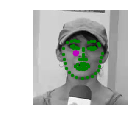

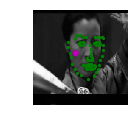

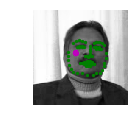

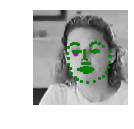

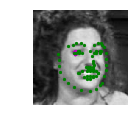

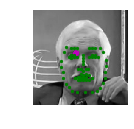

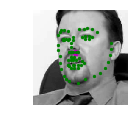

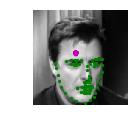

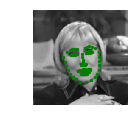

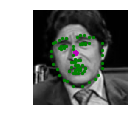

In [10]:
# 可视化预测结果
def visualize_output(test_images, test_outputs, gt_pts=None, batch_size=10):
    for i in range(batch_size):
        plt.figure(figsize=(20,10))
        ax = plt.subplot(1, batch_size, i+1)
        image = test_images[i].data
        image = image.numpy()
        predicted_key_pts = test_outputs[i].data
        predicted_key_pts = predicted_key_pts.numpy() 
        predicted_key_pts = predicted_key_pts*50.0+100
        ground_truth_pts = None
        if gt_pts is not None:
            ground_truth_pts = gt_pts[i]         
            ground_truth_pts = ground_truth_pts*50.0+100
        show_all_keypoints(np.squeeze(image), predicted_key_pts, ground_truth_pts)  
        plt.axis('off')
    plt.show()
test_images, test_outputs, gt_pts=net_sample_output()
visualize_output(test_images, test_outputs, gt_pts)

## 训练

#### 损失函数
训练一个用于预测关键点的网络与训练一个用于预测类的网络不同。你可能希望选择适合回归的损失函数，而不是输出类的分布并使用交交叉熵损失函数，因为损失函数可以用于直接比较预测值和目标值。有关各种损失函数（如MSE或L1 / SmoothL1损失），请阅读 [本文档](http://pytorch.org/docs/master/_modules/torch/nn/modules/loss.html)中的内容。

### TODO: 定义损失与优化

接下来，你需要通过定义损失函数和优化程序来定义模型的训练方式。

---

In [11]:
#定义损失函数和优化器
import torch.optim as optim
criterion = nn.SmoothL1Loss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, net.parameters()), lr = 0.001)

## 训练与初步观察

现在，你要使用大量epoch，从`train_loader`中训练你的批量训练数据。

为了快速观察你的模型是如何训练并决定是否应该修改它的结构或超参数，我们建议你最开始的时候使用一个或两个epoch。训练时，请注意观察模型的损失会如何随着时间的推移而变化：例如，它会先快速减少然后再减慢吗？或者起初会在一段时间后出现减少？如果更改了训练数据的批量大小或修改损失函数，会发生什么变化？

在使用多个epoch进行训练并创建最终模型之前，使用这些初始观察值对模型进行更改并确定一个最佳架构。

In [12]:
#验证集损失
def validation_loss(valid_loader, net):
    net.eval()
    running_loss = 0.0
    n=0
    for i, batch in enumerate(valid_loader):
        n+=1
        images = batch['image']
        key_pts = batch['keypoints']
        key_pts = key_pts.view(key_pts.size(0), -1)
        key_pts = key_pts.type(torch.FloatTensor)
        images = images.type(torch.FloatTensor)
        output_pts = net(images)
        loss = criterion(output_pts, key_pts)
        running_loss += loss.item()
    avg_loss = running_loss/(n)
    return avg_loss
def train_net(n_epochs):
    net.train()
    for epoch in range(n_epochs):
        print("开始第%.2d轮了" % (epoch+1))
        running_loss = 0.0
        for batch_i, data in enumerate(train_loader):
            images = data['image']
            key_pts = data['keypoints']
            key_pts = key_pts.view(key_pts.size(0), -1)
            key_pts = key_pts.type(torch.FloatTensor)
            images = images.type(torch.FloatTensor)
            images = images.to(device)
            key_pts = key_pts.to(device)
            output_pts = net(images)
            loss = criterion(output_pts, key_pts)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            val_loss = validation_loss(test_loader, net)
            if batch_i % 10 == 9:    # print every 10 batches
                print('Epoch: {}, Batch: {}, Avg. Train_Loss: {}'.format(epoch + 1, 
                                                                         batch_i+1, running_loss))
                running_loss = 0.0
        print('Epoch: {}, Avg.Val_Loss: {}'.format(epoch + 1,
                                                   validation_loss(test_loader,net)))
        model_dir = 'saved_models/'
        model_name = 'keypoints_model_'+str(epoch+1)+'.pt'
        if epoch==(n_epochs-1):
            torch.save(net.state_dict(), 'saved_models/keypoints_model_finally.pt')
        else:
            torch.save(net.state_dict(), model_dir+model_name)  
    print('Finished Training')
# from workspace_utils import active_session
#训练过程
# with active_session():#用于GPU训练的,可以不考虑
n_epochs = 5 
train_net(n_epochs)


开始第00轮了


KeyboardInterrupt: 